In [41]:
import tensorflow as tf
tf.__version__
tf.compat.v1.disable_eager_execution()

import numpy as np
from tensorflow.keras import initializers
from tensorflow.keras.layers import Input, Lambda, Conv1D, maximum, GlobalMaxPooling1D, Dense, GaussianNoise, MaxPooling1D, Flatten, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.constraints import non_neg
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

import matplotlib.pyplot as plt
import pandas as pd
import logomaker

import random
import tqdm
from tqdm import trange
from subprocess import Popen, PIPE, run
import sys
import pickle
from pyfaidx import Fasta
from  tensorflow.keras.callbacks import Callback
from tensorflow.keras.utils import Sequence
import random
import glob
import bioframe
import os
import tempfile
from collections import Counter
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.mixture import GaussianMixture
from multiprocessing import Pool

In [2]:
def construct_model(num_kernels=32,
                    kernel_width=24,
                    seq_len=None,
                    dropout_prop=0.0,
                    use_bias=False,
                    kernel_initializer=initializers.RandomNormal(stddev=0.0001, seed=12),
                    optimizer='adam',
                    activation='linear',
                    num_classes=1,
                    l1_reg=0.0,
                    l2_reg= 0.0,
                    gaussian_noise = 0.1,
                    spatial_dropout = 0.0,
                    rc = True,
                    padding="same",
                    conv_name="shared_conv"):
    if rc:
        seq_input = Input(shape=(seq_len,4))
        rc_op = Lambda(lambda x: K.reverse(x,axes=(1,2)))
        seq_rc = rc_op(seq_input)
        if gaussian_noise > 0.0:
            noisy_seq = GaussianNoise(gaussian_noise)(seq_input)
            noisy_seq_rc = rc_op(noisy_seq)
        
        shared_conv = Conv1D(num_kernels, kernel_width,
                             strides=1,
                             padding=padding, 
                             activation=activation,
                             use_bias=use_bias,
                             kernel_initializer=kernel_initializer,
                             kernel_regularizer=regularizers.l1_l2(l1=l1_reg,
                                                                   l2=l2_reg),
                             bias_initializer='zeros',
                             name=conv_name)

        if gaussian_noise > 0:
            conv_for = shared_conv(noisy_seq)
            conv_rc = shared_conv(noisy_seq_rc)
        else:
            conv_for = shared_conv(seq_input)
            conv_rc = shared_conv(seq_rc)
            

        merged = maximum([conv_for, conv_rc])
        pooled = GlobalMaxPooling1D()(merged)
        if dropout_prop > 0.0:
            dropout = Dropout(dropout_prop)(pooled)
            output = Dense(1, activation='sigmoid',
                       use_bias=True,
                       kernel_initializer=initializers.RandomUniform(minval=0.0, maxval=0.001, seed=12), 
                       kernel_constraint=non_neg(), 
                       bias_initializer='zeros',
                       name="dense_1")(dropout)
        else:
            output = Dense(1, activation='sigmoid',
                           use_bias=True,
                           kernel_initializer=initializers.RandomUniform(minval=0.0, maxval=0.001, seed=12), 
                           kernel_constraint=non_neg(), 
                           bias_initializer='zeros',
                           name="dense_1")(pooled)
        model = Model(inputs=seq_input, outputs=output)
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        model.summary()
        return model



def construct_scan_model(conv_weights):
    kernel_width = conv_weights.shape[0]
    num_kernels = conv_weights.shape[2]
    seq = Input(shape=(None,4))
    conv = Conv1D(num_kernels, kernel_width, 
                  name = 'scan_conv',
                  strides=1, 
                  padding='valid', 
                  activation='linear', 
                  use_bias=False, 
                  kernel_initializer='zeros', 
                  bias_initializer='zeros',
                  trainable=False)
    
    conv_seq = conv(seq)
    
    
    model = Model(inputs=seq, outputs=conv_seq)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.get_layer('scan_conv').set_weights([conv_weights])
    return model


def construct_score_model(conv_weights):
    kernel_width = conv_weights.shape[0]
    num_kernels = conv_weights.shape[2]
    seq = Input(shape=(None,4))
    rc_op = Lambda(lambda x: K.reverse(x,axes=(1,2)))
    seq_rc = rc_op(seq)
    
    conv = Conv1D(num_kernels, kernel_width, 
                  name = 'score_conv',
                  strides=1, 
                  padding='valid', 
                  activation='linear', 
                  use_bias=False, 
                  kernel_initializer='zeros', 
                  bias_initializer='zeros',
                  trainable=False)
    
    conv_for = conv(seq)
    conv_rc = conv(seq_rc)
    
    merged = maximum([conv_for, conv_rc])
    pooled = GlobalMaxPooling1D()(merged)
    model = Model(inputs=seq, outputs=pooled)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.get_layer("score_conv").set_weights([conv_weights])
    print(model.summary())
    return model


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [3]:
# In[10]:


# altschulEriksonDinuclShuffle.py
# P. Clote, Oct 2003

def computeCountAndLists(s):

    #Initialize lists and mono- and dinucleotide dictionaries
    List = {} #List is a dictionary of lists
    List['A'] = []; List['C'] = [];
    List['G'] = []; List['T'] = [];
    # FIXME: is this ok?
    List['N'] = []
    nuclList   = ["A","C","G","T","N"]
    s       = s.upper()
    #s       = s.replace("U","T")
    nuclCnt    = {}  #empty dictionary
    dinuclCnt  = {}  #empty dictionary
    for x in nuclList:
        nuclCnt[x]=0
        dinuclCnt[x]={}
        for y in nuclList:
            dinuclCnt[x][y]=0

    #Compute count and lists
    nuclCnt[s[0]] = 1
    nuclTotal     = 1
    dinuclTotal   = 0
    for i in range(len(s)-1):
        x = s[i]; y = s[i+1]
        List[x].append( y )
        nuclCnt[y] += 1; nuclTotal  += 1
        dinuclCnt[x][y] += 1; dinuclTotal += 1
    assert (nuclTotal==len(s))
    assert (dinuclTotal==len(s)-1)
    return nuclCnt,dinuclCnt,List


def chooseEdge(x,dinuclCnt):
    z = random.random()
    denom=dinuclCnt[x]['A']+dinuclCnt[x]['C']+dinuclCnt[x]['G']+dinuclCnt[x]['T']+dinuclCnt[x]['N']
    numerator = dinuclCnt[x]['A']
    if z < float(numerator)/float(denom):
        dinuclCnt[x]['A'] -= 1
        return 'A'
    numerator += dinuclCnt[x]['C']
    if z < float(numerator)/float(denom):
        dinuclCnt[x]['C'] -= 1
        return 'C'
    numerator += dinuclCnt[x]['G']
    if z < float(numerator)/float(denom):
        dinuclCnt[x]['G'] -= 1
        return 'G'
    numerator += dinuclCnt[x]['T']
    if z < float(numerator)/float(denom):
        dinuclCnt[x]['T'] -= 1
        return 'T'
    dinuclCnt[x]['N'] -= 1
    return 'N'

def connectedToLast(edgeList,nuclList,lastCh):
    D = {}
    for x in nuclList: D[x]=0
    for edge in edgeList:
        a = edge[0]; b = edge[1]
        if b==lastCh: D[a]=1
    for i in range(3):
        for edge in edgeList:
            a = edge[0]; b = edge[1]
            if D[b]==1: D[a]=1
    ok = 0
    for x in nuclList:
        if x!=lastCh and D[x]==0: return 0
    return 1

def eulerian(s):
    nuclCnt,dinuclCnt,List = computeCountAndLists(s)
    #compute nucleotides appearing in s
    nuclList = []
    for x in ["A","C","G","T","N"]:
        if x in s: nuclList.append(x)
    #create dinucleotide shuffle L
    firstCh = s[0]  #start with first letter of s
    lastCh  = s[-1]
    edgeList = []
    for x in nuclList:
        if x!= lastCh: edgeList.append( [x,chooseEdge(x,dinuclCnt)] )
    ok = connectedToLast(edgeList,nuclList,lastCh)
    return ok,edgeList,nuclList,lastCh


def shuffleEdgeList(L):
    n = len(L); barrier = n
    for i in range(n-1):
        z = int(random.random() * barrier)
        tmp = L[z]
        L[z]= L[barrier-1]
        L[barrier-1] = tmp
        barrier -= 1
    return L

def dinuclShuffle(s):
    ok = 0
    while not ok:
        ok,edgeList,nuclList,lastCh = eulerian(s)
    nuclCnt,dinuclCnt,List = computeCountAndLists(s)

    #remove last edges from each vertex list, shuffle, then add back
    #the removed edges at end of vertex lists.
    for [x,y] in edgeList: List[x].remove(y)
    for x in nuclList: shuffleEdgeList(List[x])
    for [x,y] in edgeList: List[x].append(y)

    #construct the eulerian path
    L = [s[0]]; prevCh = s[0]
    for i in range(len(s)-2):
        ch = List[prevCh][0]
        L.append( ch )
        del List[prevCh][0]
        prevCh = ch
    L.append(s[-1])
    #t = string.join(L,"")
    t = "".join(L)
    return t


In [4]:
def get_information_content(x):
    ic = x * np.log2((x + .001) / .25)
    if ic > 0:
        return(ic)
    else:
        return(0.0)
    
def get_info_content(ppm):
    w = ppm.shape[0]
    info = np.zeros(w)
    for i in range(w):
        for j in range(4):
            info[i] += ppm[i,j] * np.log2((ppm[i,j] + .001) / 0.25)
    return(info)
    
def trim_ppm(ppm, min_info=0.0):
    info = get_info_content(ppm)
    start_index = 0
    w = ppm.shape[0]
    stop_index = w
    for i in range(w):
        if info[i] < min_info:
            start_index += 1
        else:
            break

    for i in range(w):
        if info[w-i-1] < 0.25:
            stop_index -= 1
        else:
            break

    if np.max(info) < 0.25:
        return(ppm, 0, w)
    else:
        return(ppm[start_index:stop_index,:], start_index, stop_index)
    
DNA_SEQ_DICT = {
    'A' : [1, 0, 0, 0],
    'C' : [0, 1, 0, 0],
    'G' : [0, 0, 1, 0],
    'T' : [0, 0, 0, 1],
}

def encode_sequence(seq, N = [0, 0, 0, 0], seq_dict = None, useN = None):
    if seq_dict is None:
        seq_dict = DNA_SEQ_DICT
    if useN == 'uniform':
        N = [(1/len(seq_dict)) for _ in seq_dict]
    elif useN == 'zeros':
        N = [0 for _ in seq_dict]
    d = { **seq_dict, 'N' : N }
    return np.array([d[nuc] for nuc in list(seq)]).astype('float32')
 
def decode_sequence(encoded_seq, seq_dict = None):
    if seq_dict is None:
        seq_dict = DNA_SEQ_DICT
    seq_list = encoded_seq.astype('int').tolist()
    def decode_base(encoded_base):
        for letter,onehot in seq_dict.items():
            if np.array_equal(encoded_base, onehot):
                return letter
        return "N"
    return "".join(decode_base(b) for b in encoded_seq.astype('int'))


# In[11]:


In [5]:
# In[162]:


def load_peaks(peaks, l=None):
    data = pd.read_csv(peaks, header=0, sep="\t", skipfooter=1)
    data = data.rename(columns = {"#CHROM" : "chrom", 
                                  "START" : "start", 
                                  "END" : "end", 
                                  "fold_enrichment" : "signal",
                                  " supporting_peakcallers" : "peak_callers"})
    data["n_peak_callers"] = data.peak_callers.str.count(",") + 1
    if l is not None:
        w2 = l // 2
        data["start"] = data["abs_summit"] - w2
        data["end"] = data["abs_summit"] + w2
    return(data)

def merge_peaks(peaks_dfs, l=200):
    w2 = l // 2
    toReturn = peaks_dfs[0].copy()
    for i in range(1, len(peaks_dfs)):
        toReturn = bioframe.closest(toReturn, peaks_dfs[i], 
                               suffixes=('_1','_2'))
        toReturn = toReturn[toReturn["distance"] == 0]
        toReturn["abs_summit_1"] = (i * toReturn["abs_summit_1"] + toReturn["abs_summit_2"]) // (i+1)
        toReturn["signal_1"] = (i * toReturn["signal_1"] + toReturn["signal_2"]) / (i+1)
        toReturn = toReturn.rename(columns = {"chrom_1" : "chrom", 
                                              "start_1" : "start", 
                                              "end_1" : "end", 
                                              "signal_1" : "signal",
                                              "abs_summit_1" : "abs_summit"})
    toReturn["start"] = toReturn["abs_summit"] - w2
    toReturn["end"] = toReturn["abs_summit"] + w2
    
    return(toReturn)

In [6]:
def getFasta(bf, genomeFasta):
    genome = Fasta(genomeFasta, as_raw=True, sequence_always_upper=True)
    if "strand" in  bf:
        bf.loc[:, "seq"] = [genome[chrom][start:end] if strand == "+" else get_rc(genome[chrom][start:end]) for chrom, start, end, strand in zip(bf.chrom, bf.start, bf.end, bf.strand)]
    else:
        bf.loc[:,"seq"] = [genome[chrom][start:end] for chrom, start, end in zip(bf.chrom, bf.start, bf.end)]
    return(bf)

In [7]:
def get_ZMotif_motifs(motifs_file):
    df = pd.read_csv(motifs_file, sep="\t", header=0)
    
    kernels = sorted(df.kernel.unique().tolist())
    AUCs = dict(zip(df.kernel, df.auc))
    kernel = max(AUCs, key=AUCs.get)
    PPMs = []
    tmp_df = df[df["kernel"] == kernel]
    ppm = logomaker.alignment_to_matrix(tmp_df.seq, to_type="probability")
    ppm = ppm[["A", "C", "G", "T"]]
    w = ppm.shape[0]
    for i in range(w-30+1):
        PPMs.append([motifs_file, ppm.iloc[i:i+30,:]])
    return(PPMs)

In [8]:
def run_imap_multiprocessing(func, argument_list, num_processes):

    pool = Pool(processes=num_processes)

    result_list_tqdm = []
    for result in tqdm.tqdm(pool.imap(func=func, iterable=argument_list), total=len(argument_list)):
        result_list_tqdm.append(result)

    return result_list_tqdm

def ppm_to_pwm(ppm):
    pwm = ppm + 1e-5
    pwm = pwm / 0.25
    pwm = np.log2(pwm)
    return(pwm)

def flatten(xss):
    return [x for xs in xss for x in xs]

In [9]:
def get_STREME_motifs(stremePkl):
    with open(stremePkl, "rb") as f:
        PPMs = pickle.load(f)
    return([[stremePkl + "-" + _, PPMs[_]] for _ in PPMs])

In [10]:
def get_data(TF, assay, peaks="all", cycle = "last", l = 300):
    genomeFasta = "/home/gregory.andrews-umw/data/genome/hg38.fa"
    if assay == "CHS":
        dataFiles = glob.glob("/pi/zhiping.weng-umw/home/gregory.andrews-umw/IBIS/data/" + assay + "/" + TF + "/*" )
        print(dataFiles)
        print(l)
        CHS_data = [load_peaks(_, l) for _ in dataFiles]
        if peaks == "shared":
            print("Merging peaks")
            CHS_data = merge_peaks(CHS_data, l=l)
        else:
            CHS_data = pd.concat(CHS_data)

        data = CHS_data[["chrom", "start", "end", "abs_summit", "signal"]]
    else:
        GHTS = glob.glob("/pi/zhiping.weng-umw/home/gregory.andrews-umw/IBIS/data/" + assay + "/" + TF + "/*" )
        cycles = sorted([os.path.basename(_).split(".")[-2] for _ in GHTS])
        print(cycles)
        if cycle == "last":
            max_cycle = cycles[-1]
            print("Last cycle: {}".format(max_cycle))
            GHTS = [_ for _ in GHTS if "." + max_cycle + "." in _]
        print(l)
        GHTS_data = [load_peaks(_, l) for _ in GHTS]
        
        GHTS_data = pd.concat(GHTS_data)
        
        data = GHTS_data[["chrom", "start", "end", "abs_summit", "signal"]]
        print(data.shape)
    data = data.sort_values(['chrom', 'start'], ascending=[True, True]).reset_index(drop=True)
    data = getFasta(data, genomeFasta)
    return(data)

In [11]:
def get_auroc(x):
    yTest, yPred = x
    return(roc_auc_score(yTest, yPred))

In [18]:
def get_PPMs(TF, train_assay):
    motifs_files = glob.glob("../Results/G2A/{}-{}*/motifs.txt.gz".format(TF, train_assay))
    ZMotif_PPMs = flatten(run_imap_multiprocessing(get_ZMotif_motifs, motifs_files, 12))
    STREME_files = glob.glob("../Results/G2A/{}-{}*/streme.pkl".format(TF, train_assay))
    print(STREME_files)
    STREME_PPMs = run_imap_multiprocessing(get_STREME_motifs, STREME_files, 12)
    STREME_PPMs = flatten(STREME_PPMs)
    PPMs = ZMotif_PPMs + STREME_PPMs
    return(PPMs)

In [29]:
def score_motifs(PPMs, TF, test_assay):
    genomeFasta = "/home/gregory.andrews-umw/data/genome/hg38.fa"
    PWMs = [ppm_to_pwm(_[1]) for _ in PPMs]
    weights = np.zeros([len(PWMs), 30, 4])
    for i, pwm in enumerate(PWMs):
        w = pwm.shape[0]
        if w > 0:
            start = (30 - w) // 2
            stop = start + pwm.shape[0]
            weights[i,start:stop,:] = pwm
    weights = np.moveaxis(weights,0,-1)
    model = construct_score_model(weights)
    aug_by = 0
    if test_assay == "GHTS":
        l = 100
    else:
        l = 300
        
    nNegs = 1
    data = get_data(TF, test_assay,
                    peaks="all", 
                    cycle="last", l=l)
    min_n = 20000
    data = data.sample(n=min_n, replace=True, weights="signal")
    if aug_by > 0:
        aug = np.random.randint(-aug_by, aug_by, size=data.shape[0])
        data.loc[:,"start"] = data["start"] + aug
        data.loc[:,"end"] = data["end"] + aug
    data = data.sort_values(['chrom', 'start'], ascending=[True, True]).reset_index(drop=True)
    data = getFasta(data, genomeFasta)
    
    Xpos = np.array([encode_sequence(seq) for seq in data.seq])
    negSeqs = []
    for seq in data.seq:
        for i in range(nNegs):
            negSeqs.append(dinuclShuffle(seq))
    
    Xneg = np.array([encode_sequence(seq) for seq in negSeqs])
    yTest = np.array([1 for _ in range(Xpos.shape[0])] + [0 for _ in range(Xneg.shape[0])])
    X = np.vstack([Xpos, Xneg])
    scores = model.predict(X, verbose=1)
    aucs = run_imap_multiprocessing(get_auroc, [[yTest, scores[:,i]] for i in range(len(PWMs))], 12)
    return(aucs, yTest, scores)

In [20]:
TF = "GABPA"
train_assay = "CHS"
test_assay = "GHTS"
PPMs = get_PPMs(TF, train_assay)

100%|██████████| 80/80 [00:01<00:00, 43.42it/s]


[]


0it [00:00, ?it/s]


In [35]:
AUCs, yTest, scores = score_motifs(PPMs, TF, test_assay)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, None, 4)      0           input_4[0][0]                    
__________________________________________________________________________________________________
score_conv (Conv1D)             (None, None, 880)    105600      input_4[0][0]                    
                                                                 lambda_3[0][0]                   
__________________________________________________________________________________________________
maximum_3 (Maximum)             (None, None, 880)    0           score_conv[0][0]           

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  """


40000/40000 [==============================] - 3s 70us/sample


100%|██████████| 880/880 [00:01<00:00, 477.76it/s]


In [38]:
np.argmax(AUCs)

249

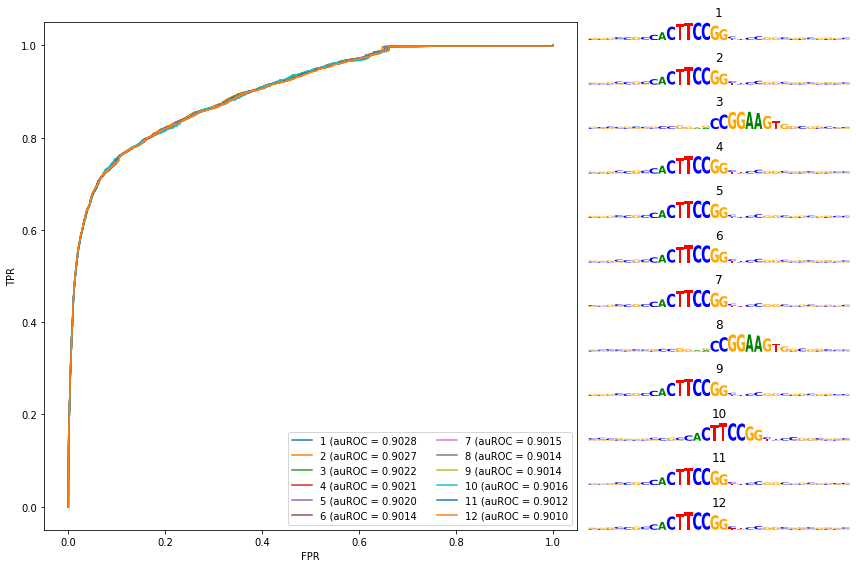

In [77]:
fig = plt.figure(figsize=(12,8), tight_layout=True)
gs = fig.add_gridspec(12, 12)
ax1 = fig.add_subplot(gs[:, :8])
logo_axes = [fig.add_subplot(gs[i, 8:]) for i in range(12)]
for plot_i, i in enumerate(np.argsort(aucs)[::-1][:12]):
    fpr, tpr, r = roc_curve(yTest, scores[:,i])
    auROC = roc_auc_score(yTest, scores[:,i])
    ax1.plot(fpr, tpr, label="{0} (auROC = {1:.4f}".format(plot_i+1, auROC))
    ax1.set_xlabel("FPR")
    ax1.set_ylabel("TPR")
    ppm = PPMs[i][1]
    ppm = pd.DataFrame(ppm, columns=["A", "C", "G", "T"]).reset_index(drop=True)
    logomaker.Logo(ppm.applymap(get_information_content), ax=logo_axes[plot_i])
    logo_axes[plot_i].axis("off")
    logo_axes[plot_i].set_ylim([0,2])
    logo_axes[plot_i].set_title(plot_i+1)
ax1.legend(loc='lower right', ncol=2)
# ax.set_ylim([0,2])